# Analysis of simulated IP grouped by model parameters and years

### Import libraries

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.transforms as tf
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import cm, colormaps, colors, transforms

### Helper functions, variables and classes

In [2]:
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

In [3]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

### Loading precalculated arrays

In [4]:
wrf_N_days = 4992
inm_N_days = 3650

In [5]:
wrf_dt_indicies = np.array(
    [dt.date(1980, 1, 1) + dt.timedelta(i * 3) for i in range(wrf_N_days)]
)

inm_dt_indicies = np.array(
    [dt.date(2022, 1, 1) + dt.timedelta(i % 365) for i in range(inm_N_days)]
)

In [6]:
wrf_LATxMON_t2 = np.load("./data/WRF/WRF_T2_LATxMON.npy")

wrf_LATxMON_ip = {
    key: np.load(f"./data/WRF/WRF_IP_{parameters}_LATxMON.npy")
    for key, parameters in zip([500, 800, 1000, 1200],
                              ["500_T2_25", "800", "1000", "1200"])
}

inm_LATxMON_ip = {
    key: np.load(f"./data/INMCM/INMCM_IP_{parameters}_LATxMON.npy")
    for key, parameters in zip([800, 1000, 1200],
                              ["800", "1000", "1200"])
}

wrf_hourly_total_ip = {
    key: np.load(f"./data/WRF/WRF_HOURLY_TOTAL_IP_{parameters}.npy")
    for key, parameters in zip([500, 800, 1000, 1200],
                              ["500_T2_25", "800", "1000", "1200"])
}

inm_hourly_total_ip = {
    key: np.load(f"./data/INMCM/INMCM_HOURLY_TOTAL_IP_{parameters}.npy")
    for key, parameters in zip([800, 1000, 1200],
                              ["800", "1000", "1200"])
}

### Figure 1

In [7]:
data = np.zeros((7, 12))
data_counter = np.zeros((7, 12), dtype=int)
data_sqr = np.zeros((7, 12))

for j, cape_thres in enumerate([800, 1000, 1200]):
    for m in range(12):

        # fill data for WRF panels
        ax_idx = j * 2

        wrf_inds =[i for i, date in enumerate(wrf_dt_indicies) if date.month == m + 1]
        ip = np.load(f"./data/WRF/WRF_HOURLY_TOTAL_IP_{cape_thres}.npy")[wrf_inds]
        data[ax_idx, m] = ip.mean()
        data_counter[ax_idx, m] = len(ip)
        data_sqr[ax_idx, m] = np.sum(
            ip.mean(axis=-1) ** 2
        ) / len(ip)

        # fill data for INMCM panels
        ax_idx = j * 2 + 1

        inmcm_inds =[i for i, date in enumerate(inm_dt_indicies) if date.month == m + 1]
        ip = np.load(f"./data/INMCM/INMCM_HOURLY_TOTAL_IP_{cape_thres}.npy")[inmcm_inds]

        data[ax_idx, m] = ip.mean()
        data_counter[ax_idx, m] = len(ip)
        data_sqr[ax_idx, m] = np.sum(
            ip.mean(axis=-1) ** 2
        ) / len(ip)

# latest point is Vostok results from previous script
# keys: mean, counter, sqr
# index 0: 2006-2020, index 1: 2006-2012, index 2: 2013-2020
vostok_results = np.load("./data/Vostok/vostok_2006_2020_results.npz")

data[-1] = vostok_results["mean"][0]
data_counter[-1] = vostok_results["counter"][0]
data_sqr[-1] = vostok_results["sqr"][0]

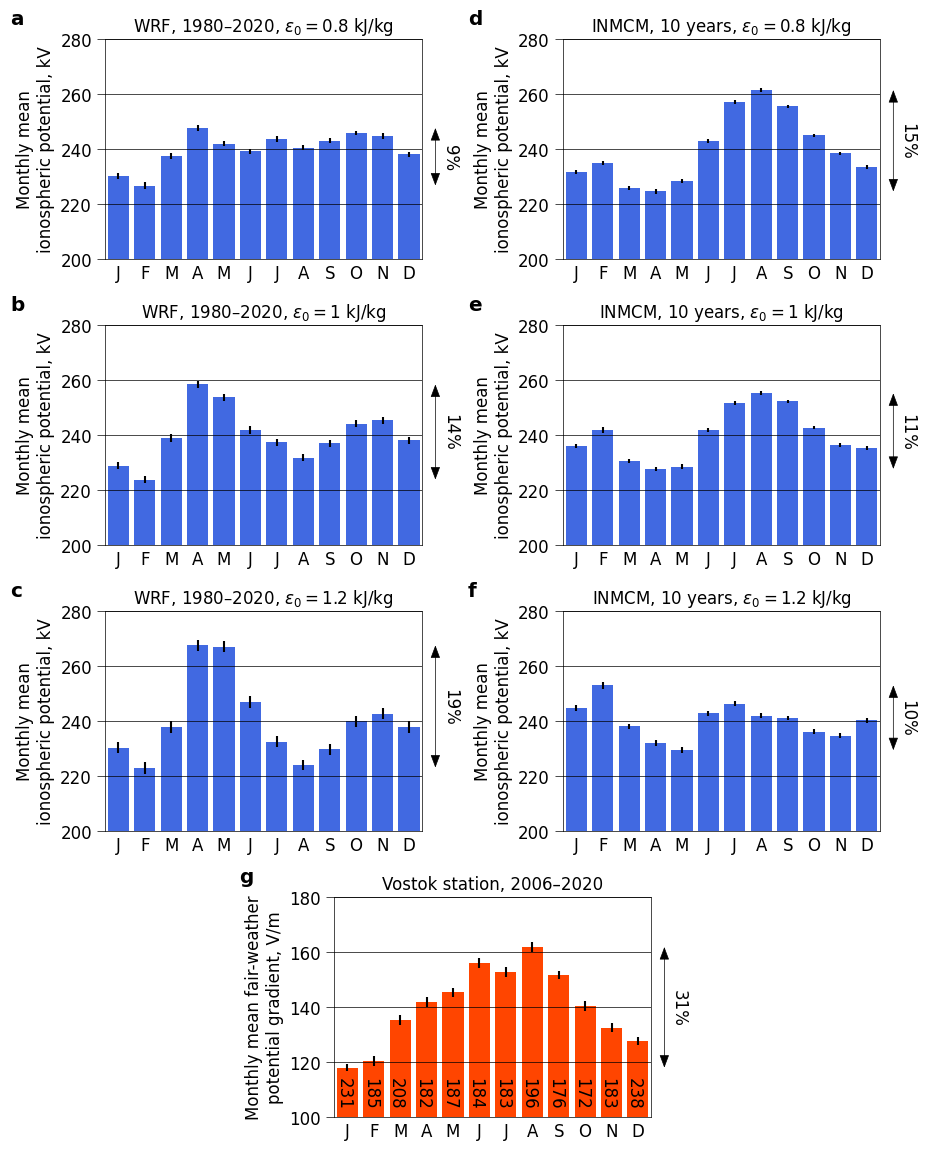

In [8]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(7)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))
ax[6] = fig.add_subplot(4, 4, (14, 15))

low = [200e3] * 6 + [100]
high = [280e3] * 6 + [180]
step = [20e3] * 6 + [20]
coeff = [1e3] * 6 + [1]
caption = ["WRF, 1980–2020, $\\varepsilon_0 = 0.8$ kJ/kg",
           "INMCM, 10 years, $\\varepsilon_0 = 0.8$ kJ/kg",
           "WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 1980–2020, $\\varepsilon_0 = 1.2$ kJ/kg",
           "INMCM, 10 years, $\\varepsilon_0 = 1.2$ kJ/kg",
           "Vostok station, 2006–2020"]

col = ["royalblue"] * 6 + ["orangered"]

for n in range(7):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    if n < 6:
        ax[n].set_ylabel("Monthly mean\nionospheric potential, kV",
                         fontsize="large")
    else:
        ax[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                         fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ax[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                   xytext=(12, np.max(data[n])), textcoords="data",
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle="arc3,rad=0.", fc="black",
                       linewidth=0.5
                   ))
    # ampl = (np.max(data[n]) - np.min(data[n])) / np.mean(data[n])
    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f"{ampl * 100:.0f}%",
               fontsize="large", ha="left", va="center", rotation=270)

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])

for n in range(7):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(6):
    ax[n].text(-0.3, 1.05, chr(ord("a") + 3 * (n % 2) + n // 2),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)
ax[6].text(-0.3, 1.05, chr(ord("a") + 6), fontsize="x-large",
           fontweight="semibold", ha="left", va="bottom",
           transform=ax[6].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for m in range(12):
    ax[6].annotate(f"{data_counter[6, m]}",
                   xy=(m-0.15, ax[6].get_ylim()[0] + 3),
                   rotation=270, ha="center", va="bottom",
                   fontsize="large", color="0.")

fig.savefig("./figures_two_parts/ip_pg_total.eps", bbox_inches="tight")

### Figure 5

In [9]:
data = np.zeros((8, 12))
data_counter = np.zeros((8, 12), dtype=int)
data_sqr = np.zeros((8, 12))

ranges = {
    0: range(1981, 1990 + 1),
    1: range(1991, 2000 + 1),
    2: range(2001, 2010 + 1),
    3: range(2011, 2020 + 1),
}

inm_splitted_indicies = {
    4: np.split(np.arange(len(inm_dt_indicies)), 2)[0],
    5: np.split(np.arange(len(inm_dt_indicies)), 2)[1]
}

for m in range(12):
    for ax_idx in range(6):
        if ax_idx in [0, 1, 2, 3]:
            wrf_inds = [
                i
                for i, date in enumerate(wrf_dt_indicies)
                if date.month == m + 1 and date.year in ranges[ax_idx]
            ]
            ip = np.load(f"./data/WRF/WRF_HOURLY_TOTAL_IP_{1000}.npy")[wrf_inds]
            data[ax_idx, m] = ip.mean()
            data_counter[ax_idx, m] = len(ip)
            data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

        if ax_idx in [4, 5]:
            inmcm_inds = [
                i for i, date in enumerate(inm_dt_indicies) if date.month == m + 1
            ]
            inmcm_inds = np.intersect1d(inmcm_inds, inm_splitted_indicies[ax_idx])
            ip = np.load(f"./data/INMCM/INMCM_HOURLY_TOTAL_IP_{1000}.npy")[inmcm_inds]
            data[ax_idx, m] = ip.mean()
            data_counter[ax_idx, m] = len(ip)
            data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

# latest point is Vostok results from previous script
# keys: mean, counter, sqr
# index 0: 2006-2020, index 1: 2006-2012, index 2: 2013-2020
vostok_results = np.load("./data/Vostok/vostok_2006_2020_results.npz")

data[-2] = vostok_results["mean"][1]
data_counter[-2] = vostok_results["counter"][1]
data_sqr[-2] = vostok_results["sqr"][1]

data[-1] = vostok_results["mean"][2]
data_counter[-1] = vostok_results["counter"][2]
data_sqr[-1] = vostok_results["sqr"][2]

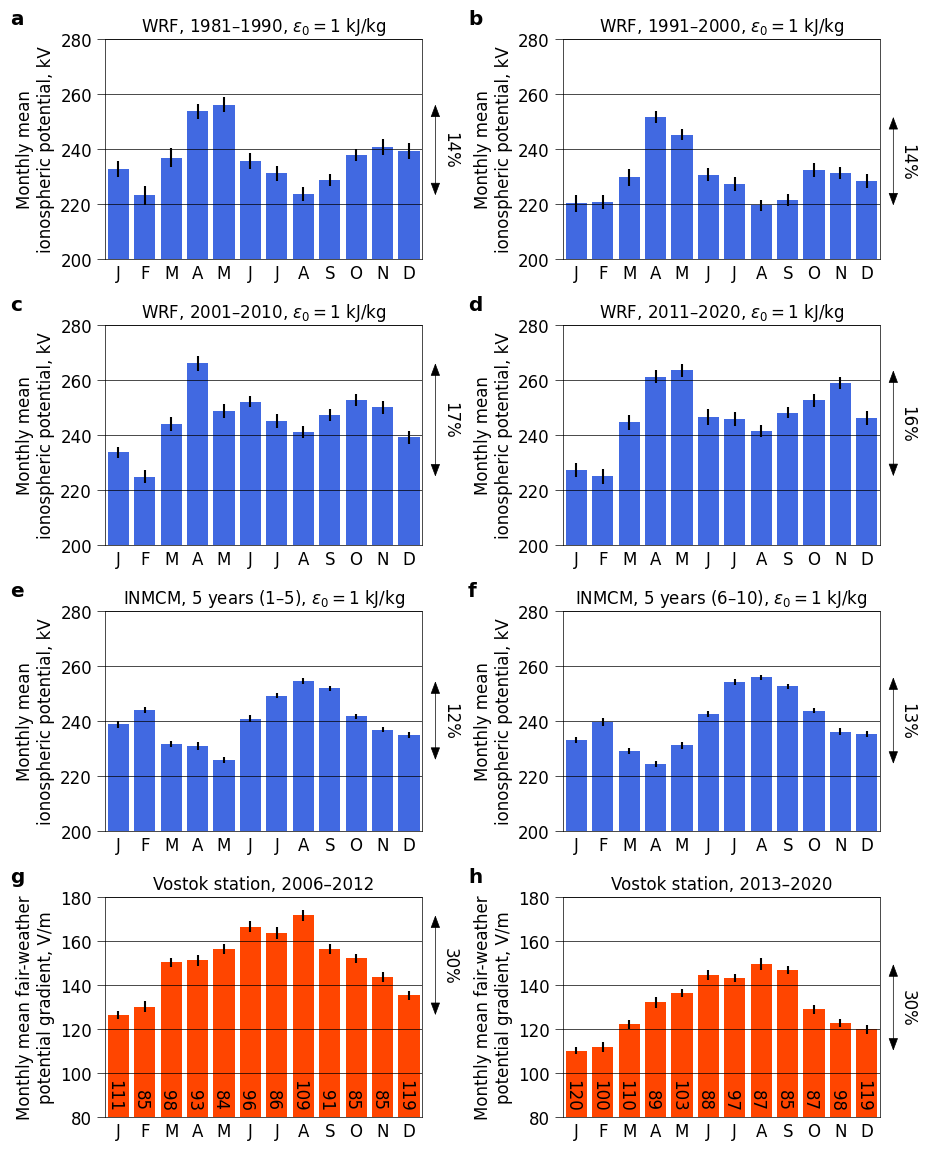

In [10]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(8)]
# for n in range(8):
#     ax[n] = fig.add_subplot(4, 2, n + 1)
for n in range(8):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [200e3] * 6 + [80] * 2
high = [280e3] * 6 + [180] * 2
step = [20e3] * 6 + [20] * 2
coeff = [1e3] * 6 + [1] * 2
caption = ["WRF, 1981–1990, $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 1991–2000, $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 2001–2010, $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 2011–2020, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 5 years (1–5), $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 5 years (6–10), $\\varepsilon_0 = 1$ kJ/kg",
           "Vostok station, 2006–2012",
           "Vostok station, 2013–2020"]

col = ["royalblue"] * 6 + ["orangered"] * 2

for n in range(8):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    if n <= 5:
        ax[n].set_ylabel("Monthly mean\nionospheric potential, kV",
                         fontsize="large")
    else:
        ax[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                         fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ax[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                   xytext=(12, np.max(data[n])), textcoords="data",
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle="arc3,rad=0.", fc="black",
                       linewidth=0.5
                   ))
    # ampl = (np.max(data[n]) - np.min(data[n])) / np.mean(data[n])
    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f"{ampl * 100:.0f}%",
               fontsize="large", ha="left", va="center", rotation=270)

fig.align_ylabels([ax[0], ax[2], ax[4], ax[6]])
fig.align_ylabels([ax[1], ax[3], ax[5], ax[7]])

for n in range(8):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(8):
    ax[n].text(-0.3, 1.05, chr(ord("a") + n), fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(6, 8):
    for m in range(12):
        ax[n].annotate(f"{data_counter[n, m]}",
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha="center", va="bottom",
                       fontsize="large", color="0.")

fig.savefig("./figures_two_parts/ip_pg_partial.eps", bbox_inches="tight")